In [1]:
using MPSExperiments
using MatrixProductBP, MatrixProductBP.Models
using IndexedGraphs, Graphs
using Plots, Statistics

In [19]:
nA = 10^4
nB = nA
kA = 3
kB = kA

β = 1.0
JA = 0.3
JB = 0.6
h = 0.2;

In [20]:
n = nA + nB
include("random_bipartite_regular.jl")
A = random_bipartite_regular(nA, nB, kA, kB)
gg = BipartiteIndexedGraph(A)
g = IndexedBiDiGraph(adjacency_matrix(gg));

## Montecarlo


In [21]:
T = 100
w = map(vertices(g)) do i
    fill(HomogeneousGlauberFactor(i ≤ nA ? JA : JB, h, β), T+1)
end
m⁰ = 0.0
ϕ = fill([ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T], n)

bp = mpbp(g, w, fill(2, n), T; ϕ)
sms = SoftMarginSampler(bp);

In [22]:
sample!(sms, 5*10^2);

SoftMargin sampling  99%|███████████████████████████████▊|  ETA: 0:00:00

In [23]:
spin(x, i) = 3-2x
spin(x) = spin(x, 0)
m_mc = [[mss.val for mss in ms] for ms in means(spin, sms)];

Marginals from Soft Margin 100%|█████████████████████████| Time: 0:00:02


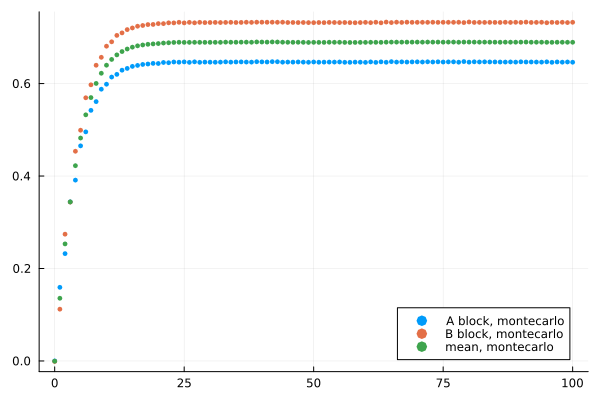

In [24]:
pl_mc = plot()
scatter!(0:T, mean(m_mc[1:nA]), label="A block, montecarlo"; m=:o, ms=2.5, msc=:auto)
scatter!(0:T, mean(m_mc[nA+1:end]), label="B block, montecarlo"; m=:o, ms=2.5, msc=:auto)
scatter!(0:T, mean(m_mc), label="mean, montecarlo"; m=:o, ms=2.5, msc=:auto)

## MPBP

In [36]:
w = [
    fill(HomogeneousGlauberFactor(JA, h, β), T+1),
    fill(HomogeneousGlauberFactor(JB, h, β), T+1)
]
ϕ = fill([t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T], 2)
bp = mpbp_infinite_bipartite_graph((kA,kB), w, (2, 2), ϕ);

In [37]:
cb = CB_BP(bp)
iterate!(bp; maxiter=20, svd_trunc=TruncBond(12), cb, tol=1e-5);

Running MPBP: iter 2    Time: 0:00:00

Running MPBP: iter 3    Time: 0:00:08

Running MPBP: iter 4    Time: 0:00:40

Running MPBP: iter 5    Time: 0:01:13

Running MPBP: iter 6    Time: 0:01:47

Running MPBP: iter 7    Time: 0:02:19

Running MPBP: iter 8    Time: 0:02:52

Running MPBP: iter 9    Time: 0:03:23

Running MPBP: iter 10    Time: 0:03:55

Running MPBP: iter 11    Time: 0:04:28

Running MPBP: iter 12    Time: 0:05:00

Running MPBP: iter 13    Time: 0:05:33

Running MPBP: iter 14    Time: 0:06:05

Running MPBP: iter 15    Time: 0:06:38

Running MPBP: iter 16    Time: 0:07:11

Running MPBP: iter 17    Time: 0:07:43

Running MPBP: iter 18    Time: 0:08:13

Running MPBP: iter 19    Time: 0:08:45

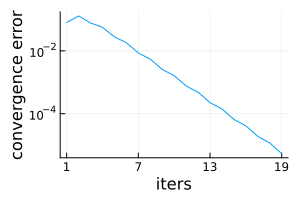

In [38]:
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

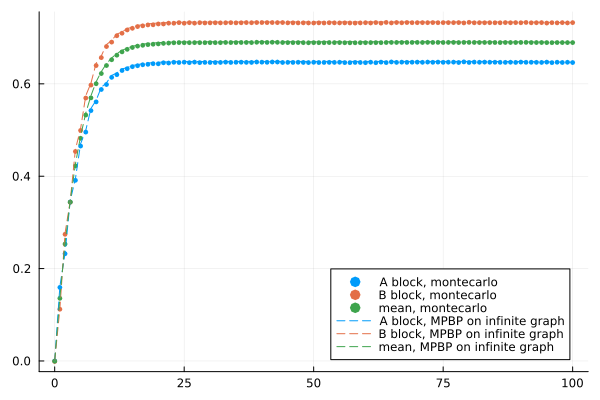

In [39]:
m_bp = means(spin, bp)

pl_bp = deepcopy(pl_mc)
plot!(pl_bp, 0:T, m_bp[1], c=theme_palette(:auto)[1],
    label="A block, MPBP on infinite graph", ls=:dash)
plot!(pl_bp, 0:T, m_bp[2], c=theme_palette(:auto)[2],
    label="B block, MPBP on infinite graph", ls=:dash)
plot!(pl_bp, 0:T, (m_bp[1]*kB + m_bp[2]*kA) / (kA+kB), c=theme_palette(:auto)[3], 
    label="mean, MPBP on infinite graph", ls=:dash)
plot!(pl_bp, legend=:bottomright)

## BP + VUMPS

In [14]:
fA = HomogeneousGlauberFactor(JA, h)
fB = HomogeneousGlauberFactor(JB, h);

In [27]:
d = 10

A0 = reshape([0.45 0.45; 0.1 0.1], 1, 1, 2, 2)
B0 = copy(A0)
# A0 = copy(A)
# B0 = copy(B)

A, B, maxiter, εs, errs, ovls, beliefs, beliefsA, beliefsB, As, Bs = iterate_bp_vumps_bipartite(
    fA, fB, d; A0, B0
)

┌ Info: VOMPS init:	err = 1.3326e-01
└ @ MPSKit /home/crotti/.julia/dev/MPSKit/src/algorithms/approximate/vomps.jl:26
┌ Info: VOMPS   1:	err = 1.9565357801e-01	time = 0.00 sec
└ @ MPSKit /home/crotti/.julia/dev/MPSKit/src/algorithms/approximate/vomps.jl:57
┌ Info: VOMPS   2:	err = 1.8608581237e-04	time = 0.01 sec
└ @ MPSKit /home/crotti/.julia/dev/MPSKit/src/algorithms/approximate/vomps.jl:57
┌ Info: VOMPS   3:	err = 4.6731631827e-10	time = 0.01 sec
└ @ MPSKit /home/crotti/.julia/dev/MPSKit/src/algorithms/approximate/vomps.jl:57
┌ Info: VOMPS conv 4:	err = 7.6729294339e-16	time = 0.02 sec
└ @ MPSKit /home/crotti/.julia/dev/MPSKit/src/algorithms/approximate/vomps.jl:51
┌ Info: VOMPS init:	err = 2.3816e-01
└ @ MPSKit /home/crotti/.julia/dev/MPSKit/src/algorithms/approximate/vomps.jl:26
┌ Info: VOMPS   1:	err = 1.6247321840e-04	time = 0.02 sec
└ @ MPSKit /home/crotti/.julia/dev/MPSKit/src/algorithms/approximate/vomps.jl:57
┌ Info: VOMPS   2:	err = 3.1866184105e-05	time = 0.02 sec
└ @ MPSK

([1.0 -0.3182814117139156 … 0.10544784564093126 0.2444627007589145; 0.016981963517485668 -0.13887971390757362 … -0.036500324058014774 -0.15891574899922467; … ; -0.005591098368212561 -0.3330532280762874 … -0.07901087240624258 -0.3159650413312713; 0.013713182173449329 -0.40003295157886365 … -0.19213490271017863 -0.2571441159727324;;; 0.23970045711433957 -0.26303903992623107 … -0.6554112128406921 -0.15610524690879093; 0.054120792754764946 0.03544825049361198 … -0.3308938533151994 0.05175678864445591; … ; 0.03624287856133985 -0.272933327296945 … 0.16677548743513237 -0.06592855232329248; 0.01040991459941801 -0.31598372858208185 … 0.38078980009568286 -0.042048258819972276;;;; 0.8268490293615167 0.4739676073244245 … 0.13821379679602383 -0.17566939663016812; 0.009055750015989522 0.11330716339262707 … -0.12345750048708445 -0.11401905708243944; … ; -0.01105494773167015 0.14687002012075293 … -0.25497044978278444 -0.18886036517421162; -0.00041337138337002366 0.04802455938840951 … -0.37293740605441

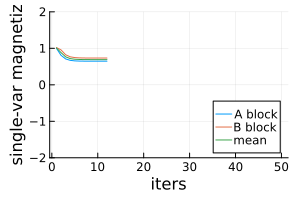

In [29]:
mA = [reduce(-, b) for b in beliefsA]
mB = [reduce(-, b) for b in beliefsB]
m = [reduce(-, b) for b in beliefs]

pl = plot()
plot!(mA, ylabel="single-var magnetiz", label="A block")
plot!(mB, ylabel="single-var magnetiz", label="B block")
plot!(m, ylabel="single-var magnetiz", label="mean")
plot!(ylims=(-2,2), legend=:bottomright, xlabel="iters", size=(300,200))

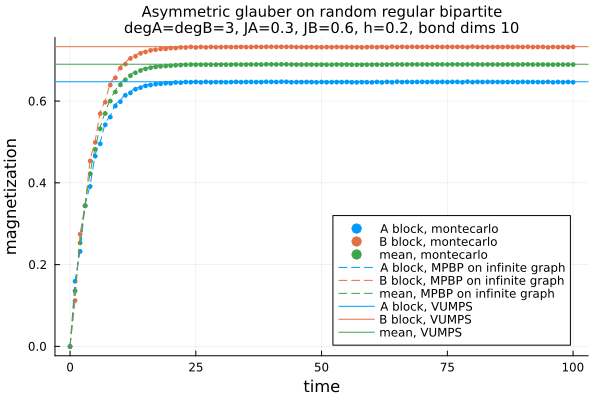

In [41]:
mAstat = mA[findlast(!isnan, mA)]
mBstat = mB[findlast(!isnan, mB)]
mstat = m[findlast(!isnan, m)]

pl2 = deepcopy(pl_bp)
plot!(pl2, title="Asymmetric glauber on random regular bipartite\ndegA=degB=3, JA=$JA, JB=$JB, h=$h, bond dims $d",
    titlefontsize=10, xlabel="time", ylabel="magnetization")
hline!(pl2, [mAstat], c=theme_palette(:auto)[1], label="A block, VUMPS")
hline!(pl2, [mBstat], c=theme_palette(:auto)[2], label="B block, VUMPS")
hline!(pl2, [mstat], c=theme_palette(:auto)[3], label="mean, VUMPS")